In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import json


from apelfei.contrast import ContrastResults, collect_all_data_setup_configs, estimate_stellar_flux
from apelfei.contrast.preparation import calculate_planet_positions
from apelfei.utils.general import center_subpixel
from apelfei.utils.data_handling import open_fits, save_as_fits, load_adi_data
from apelfei.utils.aperture_photometry import flux_ratio2mag, mag2flux_ratio, AperturePhotometryMode

Found installation of parallel_sort and use it.


## Load all config files and residuals

In [2]:
experiment_root = "../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/"

In [3]:
all_configs = collect_all_data_setup_configs(os.path.join(experiment_root, 
                                                          "configs_cmap"))

In [4]:
# collect all the residual files with configs
all_method_results = dict()
algorithm_config_dir = os.path.join(experiment_root, "configs_algo")

for tmp_file in sorted(os.listdir(algorithm_config_dir)):
    # ignore system files
    if tmp_file.startswith("."):
        continue

    tmp_algo_config_file = os.path.join(algorithm_config_dir, tmp_file)
    with open(tmp_algo_config_file) as json_file:
        tmp_algorithm_config = json.load(json_file)
    
    tmp_algo = tmp_algorithm_config['method_name']
    print("Found algorithm config file for method " + str(tmp_algo))
    print("Collecting residuals...")
    
    # Loop over all fake planet experiments
    tmp_all_results = []
    for tmp_config in all_configs:
        tmp_id, tmp_cmap_config_file = tmp_config
        
        tmp_residual_file = os.path.join(experiment_root, 
                                         "pca_residuals",
                                         tmp_algo +"_ID_" + tmp_id + ".fits")
                  
        # save residual and config file paths
        tmp_all_results.append((tmp_cmap_config_file, tmp_residual_file))
        
    print("[DONE] - Found " + str(len(tmp_all_results)) + " residuals.")
    all_method_results[tmp_algo] = tmp_all_results

Found algorithm config file for method pca_005
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_010
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_020
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_030
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_040
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_050
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_075
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_100
[DONE] - Found 2017 residuals.


## Read the data for the PSF template

In [5]:
dataset_json_file = os.path.join(experiment_root, "dataset.json")
config_dir = os.path.join(experiment_root, "configs_cmap")
algo_config_root = os.path.join(experiment_root, "configs_algo")
residual_result_dir = os.path.join(experiment_root, "pca_residuals")

with open(dataset_json_file) as json_file:
    tmp_dataset_config = json.load(json_file)

In [6]:
# we need the psf template for contrast calculation
science_data, _, raw_psf_template_data = load_adi_data(tmp_dataset_config["file_path"],
                                                       data_tag=tmp_dataset_config["stack_key"],
                                                       psf_template_tag=tmp_dataset_config["psf_template_key"],
                                                       para_tag=tmp_dataset_config["parang_key"])

dit_psf_template = tmp_dataset_config["dit_psf_template"]
dit_science = tmp_dataset_config["dit_science"]

In [7]:
# Cut the data to the innermost 8 lambda / D
crop_science = tmp_dataset_config["crop_science"]
crop_template = tmp_dataset_config["crop_template"]

science_data = science_data[:,
                            crop_science:-crop_science,
                            crop_science:-crop_science]

psf_template_data = raw_psf_template_data[crop_template:-crop_template, 
                                          crop_template:-crop_template]

test_frame = science_data[0, :, :]

## Create the Contrast Evaluator

In [8]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [9]:
# 1.) Compute the stellar flux
stellar_flux = estimate_stellar_flux(
    psf_template=psf_template_data,
    dit_science=tmp_dataset_config["dit_science"],
    dit_psf_template=tmp_dataset_config["dit_psf_template"],
    photometry_mode=photometry_mode_planet,
    scaling_factor=1.)

In [10]:
contrast_results = dict()

for pca_setup, result_files in all_method_results.items():
    print(pca_setup)
    tmp_contrast_result = ContrastResults(model_results_in=result_files,
                                          stellar_flux=stellar_flux,
                                          planet_photometry_mode=photometry_mode_planet,
                                          noise_photometry_mode=photometry_mode_noise,
                                          psf_fwhm_radius=2.1)
    contrast_results[pca_setup] = tmp_contrast_result

pca_005
pca_010
pca_020
pca_030
pca_040
pca_050
pca_075
pca_100


## Extract the residuals of interest

In [11]:
contrast_result = contrast_results["pca_020"]

In [12]:
tmp_idx = contrast_result.m_idx_table.iloc[6, 7]  # change this to pic different (separation, fulx_ratio)
planet_idx = 0

In [13]:
tmp_tp_residual = contrast_result.m_planet_dict[tmp_idx][1][0]
fp_residual = contrast_result.m_fp_residual

difference_frame = tmp_tp_residual - fp_residual

In [14]:
contrast_result_2 = contrast_results["pca_050"]
tmp_idx_2 = contrast_result_2.m_idx_table.iloc[2, 7]
tmp_tp_residual_2 = contrast_result_2.m_planet_dict[tmp_idx_2][1][0]
fp_residual_2 = contrast_result_2.m_fp_residual

difference_frame_2 = tmp_tp_residual_2 - fp_residual_2

In [15]:
# Estimate the positions where fake planets are inserted
tmp_planet_position = contrast_result.m_planet_dict[tmp_idx][1][1]

center = center_subpixel(test_frame)
separations = np.arange(0, center[0], 4.2)[1:]
#separations = np.array([4.2, 4.2 * 3, 4.2*6.5, 4.2*7])

planet_positions = calculate_planet_positions(test_frame,
                                              psf_fwhm_radius=2.1,
                                              num_planets=6,
                                              separations=separations)

planet_positions = np.concatenate([np.array(value)[:, :2] for value in planet_positions.values()])

## Plot the Residuals

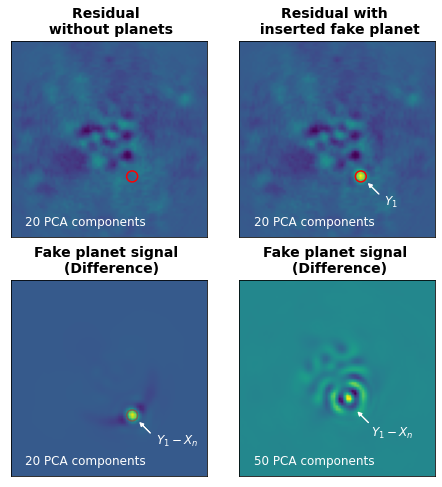

In [18]:
fig = plt.figure(constrained_layout=False, figsize=(8, 8))

gs0 = fig.add_gridspec(2, 2, width_ratios = [1, 1.0])
gs0.update(wspace=0.05, hspace=0.22)

# q-q Plots
res_without_planet_ax = fig.add_subplot(gs0[0, 0])
res_with_planet_ax = fig.add_subplot(gs0[0, 1])

res_difference_1 = fig.add_subplot(gs0[1, 0])
res_difference_2 = fig.add_subplot(gs0[1, 1])

tmp_max = np.max(tmp_tp_residual)
tmp_min = np.min(tmp_tp_residual)

# Plot the Residual without planet
res_without_planet_ax.imshow(fp_residual, 
                             vmin=tmp_min, vmax=tmp_max)
res_without_planet_ax.axes.get_yaxis().set_ticks([])
res_without_planet_ax.axes.get_xaxis().set_ticks([])

#res_without_planet_ax.scatter(np.array(planet_positions)[:,0], 
#                              np.array(planet_positions)[:,1], 
#                              marker="x", color='white', lw=7, s=1, alpha=0.6)
res_without_planet_ax.text(5, 70, "20 PCA components", color="white", fontsize=12)

res_without_planet_ax.scatter(tmp_planet_position[0],
                              tmp_planet_position[1], 
                              marker="o", facecolors='none', edgecolors='red', s=120, lw=1.5)

res_without_planet_ax.set_title("Residual \n without planets",
                                fontsize=14, fontweight="bold", y=1.01)


# Plot the Residual with planet
res_with_planet_ax.imshow(tmp_tp_residual, 
                          vmin=tmp_min, vmax=tmp_max)
res_with_planet_ax.axes.get_yaxis().set_ticks([])
res_with_planet_ax.axes.get_xaxis().set_ticks([])

res_with_planet_ax.scatter(tmp_planet_position[0],
                           tmp_planet_position[1], 
                           marker="o", facecolors='none', edgecolors='red', s=120, lw=1.5)

res_with_planet_ax.text(55, 62, r"$Y_1$", color="white", fontsize=12)
res_with_planet_ax.arrow(53, 58, -3, -3, color="white",
                         head_length=1.5,head_width=1.5)

res_with_planet_ax.text(5, 70, "20 PCA components", color="white", fontsize=12)

res_with_planet_ax.set_title("Residual with \n inserted fake planet",
                             fontsize=14, fontweight="bold", y=1.01)


# Plot the Residual difference 1
res_difference_1.imshow(difference_frame, 
                        vmin=tmp_min, vmax=tmp_max)
res_difference_1.axes.get_yaxis().set_ticks([])
res_difference_1.axes.get_xaxis().set_ticks([])

res_difference_1.scatter(tmp_planet_position[0],
                         tmp_planet_position[1], 
                         marker="o", facecolors='none', edgecolors='red', s=120, lw=1.5, alpha=0.4)

res_difference_1.text(55, 62, r"$Y_1 - X_n$", color="white", fontsize=12)
res_difference_1.arrow(53, 58, -3, -3, color="white",
                       head_length=1.5,head_width=1.5)

res_difference_1.text(5, 70, "20 PCA components", color="white", fontsize=12)

res_difference_1.set_title("Fake planet signal \n (Difference)", 
                           fontsize=14, fontweight="bold", y=1.01)

# Plot the Residual difference 2
res_difference_2.imshow(difference_frame_2)

res_difference_2.axes.get_yaxis().set_ticks([])
res_difference_2.axes.get_xaxis().set_ticks([])

res_difference_2.text(50, 59, r"$Y_1 - X_n$", color="white", fontsize=12)
res_difference_2.arrow(49, 54, -3, -3, color="white",
                       head_length=1.5,head_width=1.5)

res_difference_2.text(5, 70, "50 PCA components", color="white", fontsize=12)

res_difference_2.set_title("Fake planet signal \n (Difference)", 
                           fontsize=14, fontweight="bold", y=1.01)

fig.patch.set_facecolor('white')
plt.savefig("./11_Fake_planet_residuals.pdf", bbox_inches='tight')